# 3. Clasificación y META-Analysis 

--- 1. Cargando Predicciones del Entrenamiento ---
✅ Datos cargados: 1811278 filas.
Columnas disponibles: ['POLISSA_SUBM', 'FECHA_HORA_CRONO', 'PROB_TARGET_HOY', 'REAL_TARGET_HOY', 'PROB_TARGET_MANANA', 'REAL_TARGET_MANANA', 'PROB_TARGET_7DIAS', 'REAL_TARGET_7DIAS']

--- 2. Calculando Deltas (Evolución del Riesgo) ---
   PROB_TARGET_HOY  DELTA_CORTO  DELTA_LARGO
0         0.317676    -0.076205     0.005294
1         0.322249    -0.076483    -0.033005
2         0.333353    -0.088674    -0.057957
3         0.322249    -0.076483    -0.033005
4         0.322105    -0.078684    -0.020369

--- 3. Aplicando Reglas de Clasificación ---


Clasificando: 100%|██████████| 1811278/1811278 [00:21<00:00, 84942.39it/s]



--- 4. Resumen Final ---

Distribución de Alertas Generadas:
ESTADO_FINAL
No Fuga                            39.931363
Fuga Grave                         22.269138
No Fuga (Riesgo Bajo)              21.428130
Fuga Moderada                       8.744599
Fuga Leve (Tendencia Creciente)     6.341600
Fuga Grave (En Crecimiento)         1.285170
Name: proportion, dtype: float64

✅ Archivo final guardado en: ../data/processed-data/incidencias_clasificadas_final.csv


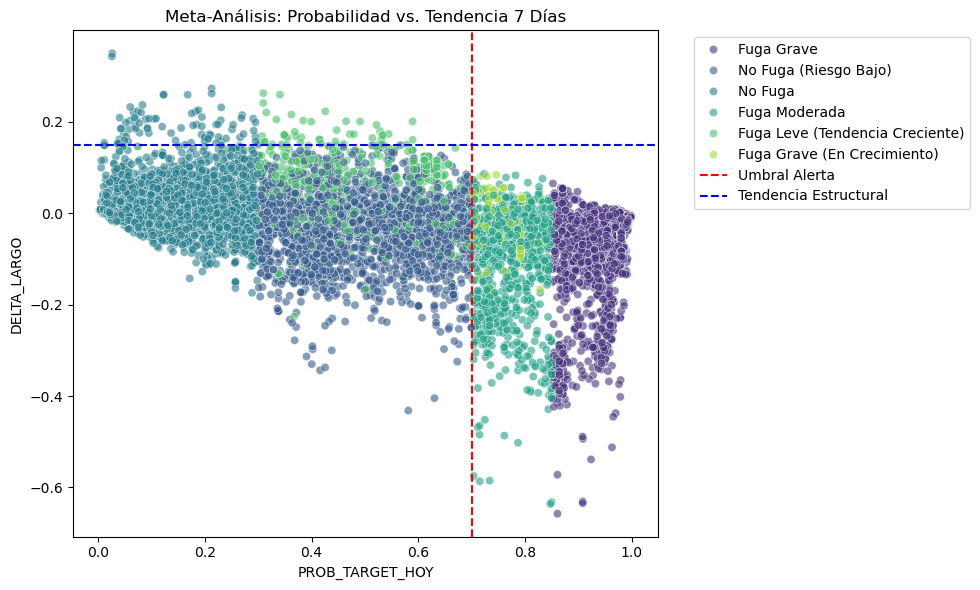

In [ ]:
# ==============================================================================
# NOTEBOOK: 03_Meta_Analysis.ipynb (VERSIÓN EFICIENTE - SIN RECÁLCULOS)
# DESCRIPCIÓN: Carga las probabilidades YA CALCULADAS en el entrenamiento (CSV)
#              y aplica la lógica de clasificación final.
# ==============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# --- 1. CONFIGURACIÓN ---
# Usamos el CSV que generaste al final del Notebook 3 (Entrenamiento)
INPUT_PREDICTIONS_CSV = '../data/processed-data/analisis_predicciones.csv'
OUTPUT_FILE = '../data/processed-data/incidencias_clasificadas_final.csv'

# --- 2. CARGA DE RESULTADOS PREVIOS ---
print("--- 1. Cargando Predicciones del Entrenamiento ---")

try:
    # Leemos el CSV asegurando el formato correcto
    df = pd.read_csv(INPUT_PREDICTIONS_CSV, sep=';', decimal=',')
    
    # Convertir fecha para ordenar
    if 'FECHA_HORA_CRONO' in df.columns:
        df['FECHA_HORA_CRONO'] = pd.to_datetime(df['FECHA_HORA_CRONO'])
        df = df.sort_values(by=['POLISSA_SUBM', 'FECHA_HORA_CRONO'])
        
    print(f"✅ Datos cargados: {len(df)} filas.")
    print("Columnas disponibles:", df.columns.tolist())
    
except FileNotFoundError:
    print(f"❌ ERROR: No existe {INPUT_PREDICTIONS_CSV}. \nEjecuta primero el Notebook 2 (Entrenamiento) para generar este archivo.")
    exit()

# --- 3. CÁLCULO DE TENDENCIAS (DELTAS) ---
print("\n--- 2. Calculando Deltas (Evolución del Riesgo) ---")

# No necesitamos modelos. Solo restamos las columnas que ya existen.
# Delta Corto: ¿Sube el riesgo mañana?
df['DELTA_CORTO'] = df['PROB_TARGET_MANANA'] - df['PROB_TARGET_HOY']

# Delta Largo: ¿Sube el riesgo en una semana?
df['DELTA_LARGO'] = df['PROB_TARGET_7DIAS'] - df['PROB_TARGET_HOY']

print(df[['PROB_TARGET_HOY', 'DELTA_CORTO', 'DELTA_LARGO']].head())


# --- 4. LÓGICA DE CLASIFICACIÓN (Tu "Semáforo") ---
print("\n--- 3. Aplicando Reglas de Clasificación ---")

def clasificar_fuga(row):
    """
    Aplica la Matriz de Decisión para etiquetar la severidad
    basándose en la probabilidad actual y la proyección futura.
    """
    p_hoy = row['PROB_TARGET_HOY']
    delta_corto = row['DELTA_CORTO']
    delta_largo = row['DELTA_LARGO']
    
    # --- TUS UMBRALES (Ajustables aquí) ---
    UMBRAL_SEGURIDAD = 0.30  # Debajo de esto, todo ok
    UMBRAL_ALERTA    = 0.70  # Zona de sospecha
    UMBRAL_CRITICO   = 0.85  # Fuga casi segura
    
    TENDENCIA_RAPIDA = 0.05  # +5% en 24h
    TENDENCIA_ESTRUCTURAL = 0.15 # +15% en 7 días
    
    # 1. NO FUGA
    if p_hoy < UMBRAL_SEGURIDAD:
        return "No Fuga"
    
    # 2. FUGA LEVE (Zona Gris)
    if p_hoy < UMBRAL_ALERTA:
        # Solo es leve si la tendencia a largo plazo es mala
        if delta_corto > TENDENCIA_RAPIDA or delta_largo > TENDENCIA_ESTRUCTURAL:
            return "Fuga Leve (Tendencia Creciente)"
        return "No Fuga (Riesgo Bajo)"

    # 3. ZONA DE ALERTA (Moderada vs Grave)
    if p_hoy < UMBRAL_CRITICO:
        # Si empeora rápido o mucho, la escalamos a GRAVE
        if delta_corto > TENDENCIA_RAPIDA or delta_largo > TENDENCIA_ESTRUCTURAL:
            return "Fuga Grave (En Crecimiento)"
        # Si es estable, se queda en MODERADA
        return "Fuga Moderada"
    
    # 4. ZONA CRÍTICA (> 0.85)
    return "Fuga Grave"

# Aplicar la lógica
tqdm.pandas(desc="Clasificando")
df['ESTADO_FINAL'] = df.progress_apply(clasificar_fuga, axis=1)


# --- 5. RESULTADOS Y GUARDADO ---
print("\n--- 4. Resumen Final ---")

# Distribución
print("\nDistribución de Alertas Generadas:")
print(df['ESTADO_FINAL'].value_counts(normalize=True) * 100)

# Guardar resultado final
df.to_csv(OUTPUT_FILE, index=False, sep=';', decimal=',')
print(f"\n✅ Archivo final guardado en: {OUTPUT_FILE}")

# Visualización del Mapa de Decisión
plt.figure(figsize=(10, 6))
# Muestreo para que el gráfico sea rápido
sample_plot = df.sample(n=min(10000, len(df)), random_state=42)

sns.scatterplot(
    data=sample_plot, 
    x='PROB_TARGET_HOY', 
    y='DELTA_LARGO', 
    hue='ESTADO_FINAL', 
    alpha=0.6, 
    palette='viridis'
)
plt.title('Meta-Análisis: Probabilidad vs. Tendencia 7 Días')
plt.axvline(0.70, color='red', linestyle='--', label='Umbral Alerta')
plt.axhline(0.15, color='blue', linestyle='--', label='Tendencia Estructural')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('../data/meta_analysis_decision_map.png')
plt.show()